# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
# number of callbacks for black-sounding names
sum(data[data.race=='w'].call)

235.0

In [5]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [6]:
w = data[data.race=='w']
b = data[data.race=='b']

# Question 1: 

**What test is appropriate for this problem? Does CLT apply?**

Using sample proportion: Permutation, bootstrapping with 2 samples, Z-test (Normal distribution to approximate binomial probabilities, allowed by the CLT), confidence interval


Discuss with Andrei: which method is the best one for this binomial distribution

# Question 2:

** What are the null and alternate hypothesis?**

- Null: the black-sounding or white-sounding names don't determine the requests for interviews from employers. Proportion of people who got a request for interview should be the same (difference in proportion should be zero)
- Alternate: black-sounding names drive less requests for interviews from employers


# Question 3:

**Permutation:**

In [7]:
b.shape

(2435, 65)

In [8]:
w.shape

(2435, 65)

In [9]:
w[w.call == 1].shape

(235, 65)

In [10]:
w[w.call == 0].shape

(2200, 65)

In [11]:
b[b.call == 1].shape

(157, 65)

In [12]:
b[b.call == 0].shape

(2278, 65)

In [13]:
b_1 = b[b.call == 1]
w_1 = w[w.call == 1]

In [14]:
# Difference in proportion from sample data:

prop_b = b_1.shape[0] / b.shape[0]
prop_w = w_1.shape[0] / w.shape[0]

diff = prop_b - prop_w
diff

prop_w

0.09650924024640657

In [15]:
# probability of getting a request for an interview from sample data, regardless of name:

data_1 = data[data.call == 1]

prob_1 = data_1.shape[0] / data.shape[0]
prob_1

# if null hypothesis is true, the proportion for black and white sounding names should be equal to prob_1

0.08049281314168377

In [65]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [66]:
def draw_perm_reps(data_1, data_2, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)

        # Compute the test statistic
        perm_replicates[i] = (np.sum(perm_sample_1) / len(perm_sample_1)) - (np.sum(perm_sample_2) / len(perm_sample_2))

    return perm_replicates

In [74]:
np.random.seed(40)

# Construct arrays of data: black-sounding, white_sounding names:
b_names = np.array([True] * 157 + [False] * 2278)
w_names = np.array([True] * 235 + [False] * 2200)


# Acquire permutation samples: perm_replicates
perm_replicates = draw_perm_reps(b_names, w_names, 10000)

# Compute and print p-value: p
p = np.sum(perm_replicates <= diff) / len(perm_replicates)
print('p-value =', p)


p-value = 0.0001


Low p-value rejects the null hypothesis that the difference in proportion of black-sounding name and white-sounding name getting a request for interview is due to chance.

**Bootstrap:**

In [19]:
# probability of getting a request for an interview from sample data, regardless of name:

data_1 = data[data.call == 1]

prob_1 = data_1.shape[0] / data.shape[0]
prob_1

# if null hypothesis is true, the proportion for black and white sounding names should be the same, so difference should be zero

0.08049281314168377

In [78]:
# Using binomial method for probability of black-sounding names (analyzing just 1 sample - black sounding names):

np.random.seed(42)
samples_binomial = np.random.binomial(n=len(b),p=prop_b, size=10000)
samples_prop = samples_binomial/10000


# checking the proportion of bootstrap samples with proportion equal or higher to the overall empirical sample proportion:
np.sum(samples_prop >= prob_1) / len(samples_prop)

0.0

No bootstrap sample as a proportion equal or higher than the overall proportion (prob_1). Due to p value equal to zero, the null hypothesis can be rejected.

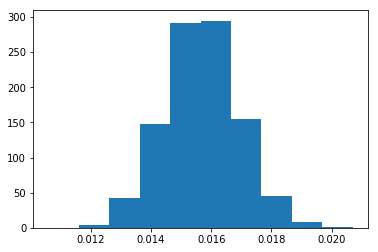

In [81]:
import matplotlib.pyplot as plt

plt.hist(samples_prop, normed=True)
plt.show()

In [82]:
# Compute the 95% confidence interval: conf_int
conf_int = np.percentile(samples_prop, [2.5, 97.5])

# Print the confidence interval
print('95% confidence interval =', conf_int, 'proportion')

95% confidence interval = [ 0.0134  0.0181] proportion


**Bootstrap 2 samples:**

In [97]:
# Difference in proportion from sample data:

prop_b = b_1.shape[0] / b.shape[0]
prop_w = w_1.shape[0] / w.shape[0]

diff = prop_b - prop_w


# Concatenate data:
call_concat = np.concatenate((w['call'], b['call'])) 

# Initialize bootstrap replicates: bs_replicates
bs_replicates = np.empty(10000)

for i in range(10000):
    # Generate bootstrap sample
    bs_sample = np.random.choice(call_concat, size=len(call_concat))
    
    # Compute replicate
    sample_1 = bs_sample[:len(w['call'])]
    sample_2 = bs_sample[len(w['call']):]
    bs_replicates[i] = (np.sum(sample_1) / len(sample_1)) - (np.sum(sample_2) / len(sample_2))

# Compute and print p-value: p
p = np.sum(bs_replicates <= diff) / len(bs_replicates)
print('p-value =', p)


# Question to Andrei: Do I need to use binomial function to run a bootstrap or can I do as this cell?

p-value = 0.0001


**Frequestist:**

In [98]:
from scipy.stats import sem
from scipy.stats import binom

# Difference in proportion from sample data:

prop_b = b_1.shape[0] / b.shape[0]
prop_w = w_1.shape[0] / w.shape[0]

diff = prop_b - prop_w

# standard error:
sem = np.sqrt((prop_b*(1-prop_b) / len(b)) + (prop_w*(1-prop_w)/len(w)))

moe = 1.96 * sem

moe

# Question to Andrei: is there a scipy funcion for sem of categorical variable, 2 samples?

0.015255406349886438

In [60]:
# Confidence interval for difference in proportion:

low_diff = diff - moe
high_diff = diff + moe

In [61]:
low_diff

-0.047288260559332024

In [62]:
high_diff

-0.016777447859559147

95% Confidence interval: -0.047288260559332024 to -0.016777447859559147

Null hypothesis (differencde zero) is not within the confidence interval so the null hypothesis can be rejected.

In [57]:
# Z-test:

std_error = np.sqrt(prob_1 * (1 - prob_1) * (1/len(b) + 1/len(w)))
z = (prop_b - prop_w) / std_error
z

-4.1084121524343464

In [99]:
import scipy.stats as st
p_value = st.norm.cdf(z)
p_value

1.9919434187925383e-05

Very low p value indicate that the null hypothesis can be rejected, meaning the difference in proportion between white-sounding names and black_sounding is significant and not due to chance.

# Question 4

Write a story describing the statistical significance in the context of the original problem.
 

In all the methods used, p value was much lower than the significance level (0.05), so the null hypothesis can be rejected, which means black-sounding names have lower rates of request for an interview.

# Question 5

Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

Discuss this question with Andrei